# Import Module

In [18]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy import stats
from sklearn.decomposition import PCA

# tqdm + Remove warnings
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')

# Settings

### Variables

In [2]:
variables = ['tas']
variable = 'tas'
TITLE = 'Surface Temperature'
ylabel = '$E_{tas}$ ($K$)'

### Paths

In [4]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/PPE/CNRM-CM6-1_PPE/'
path_files='/data/home/globc/peatier/PPE/CNRMppe_error_decomposition/files/'
path_colormaps='/data/home/globc/peatier/TOOLS/IPCC_colormaps/colormaps/'

### List of members

In [5]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# Functions

In [6]:
def MSE(mod, obs, W_rmse_2D) :
    diff_tmp = (mod - obs)**2 * W_rmse_2D
    diff = (diff_tmp.sum(['lat', 'lon']))
    return diff

In [7]:
def reconstruct_X(eofs_combined, pc, nb_dims) :
    X_rec_tmp = np.dot(eofs_combined.transpose(),pc)
    if nb_dims == 3 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat", "time"]).transpose('time', 'lat', 'lon')
    if nb_dims == 2 :
        X_rec = xr.DataArray(X_rec_tmp, 
                        dims=["lon", "lat"]).transpose('lat', 'lon')
    
    X_rec['lat'] = eofs_combined['lat']
    X_rec['lon'] = eofs_combined['lon']
    return X_rec

In [8]:
def MSE_rec(rec_anom_mod_w, rec_anom_obs_w, Mean, W_rmse_2D) :
    mod = rec_anom_mod_w/W_eof_2D + Mean
    obs = rec_anom_obs_w/W_eof_2D + Mean
    diff = MSE(mod, obs, W_rmse_2D)
    return diff

In [9]:
def get_3D_tas_xarr(path, filename, variables):
#    “”"
#    This function read the netCDF file of monthly data, compute the radiative budget, perform a yearly mean and 
#    return a dataframe
#    “”"
    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    #
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    tas = df['tas']
    #
    return tas

# Get data : obs, PPE, p1

In [10]:
path_observation = '/data/scratch/globc/peatier/obs/BEST/'
filename = 'Land_and_Ocean_LatLong1_regrid_1979-1981.nc'

In [11]:
# POUR LES OBSERVATIONS BEST

path = path_observation

file =  xr.open_mfdataset(path+filename,combine='by_coords')
clim = file['climatology'].to_dataframe()#.drop(columns='month_number')
clim = pd.concat([clim, clim, clim]).reset_index('month_number')

df_obs=file['temperature'].to_dataframe().reset_index('time')
df_obs['temperature'] = df_obs['temperature']
df_obs['clim'] = clim['climatology']
df_obs['ta'] = df_obs['temperature']+df_obs['clim']+273.15
variable_obs = 'ta'
#df_obs

In [12]:
X_obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
#X_obs

In [13]:
# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_tas_xarr(path, filename, variables)

In [19]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
for nb_p in tqdm(nb_p_list) :
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_tas_xarr(path, filename, variables)

100%|██████████| 102/102 [03:38<00:00,  2.14s/it]


In [20]:
amip['p1'] = p1_amip

# Calcule full MSE (ej)

In [21]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    amip_list[i+1] = tmp
    i+=1

In [22]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])

In [23]:
## --Get weights : 
lats = matrix['lat'].values

wgts = np.cos(np.deg2rad(lats))
W_eof_2D = sqrt(wgts)[:,np.newaxis] ## --Wqts before EOF analysis - 2D (lat x lon)
W_eof_3D = sqrt(wgts)[np.newaxis,:,np.newaxis] ## --Wqts before EOF analysis - 3D (time x lat x lon)

S = wgts.sum()*256 ## --Sum of wgts over the whole grid
wgts_sum = wgts/S
W_rmse_2D = wgts_sum[:,np.newaxis] ## -- Wgts before RMSE, divided by sum of wgts - 2D (lat x lon)

In [24]:
# Reference p1
mod = amip['p1']
obs = X_obs[variable_obs]
diff_p1 = MSE(mod, obs, W_rmse_2D)

In [25]:
ej_list = []
#ej['p1'] = diff_p1

for p in nb_p_list :
    mod = amip[p]
    obs = X_obs[variable_obs]
    diff = MSE(mod, obs, W_rmse_2D)
    ej_list.append(diff)


### Save

In [20]:
np.save(path_files+'npy/CNRMppe_decomposition_ej_'+str(variable)+'.npy', ej_list)

# EOF + truncated RMSE (rj)

## EOF

In [26]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

,Array,Chunk
Bytes,13.50 MB,131.07 kB
Shape,"(103, 128, 256)","(1, 128, 256)"
Count,861 Tasks,103 Chunks
Type,float32,numpy.ndarray


In [27]:
anom_w = (anom*W_eof_3D)#.to_array()
anom_w

,Array,Chunk
Bytes,27.00 MB,262.14 kB
Shape,"(103, 128, 256)","(1, 128, 256)"
Count,965 Tasks,103 Chunks
Type,float64,numpy.ndarray


In [28]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom_w, center=False, weights=None)

In [29]:
eof = solver.eofsAsCovariance(neofs=102, pcscaling=1)
pc = solver.pcs(npcs=102, pcscaling=1)

In [30]:
varFrac = solver.varianceFraction(neigs=102)
#varFrac

### Save

In [27]:
for i in range(0,len(eof),1) : 
    j = i+1
    # EOFmap
    EOF_df = eof[i].to_dataframe().drop(labels = 'mode', axis=1)
    EOF_df.to_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy")

In [35]:
## --Save the pc_p1 and pc_PPE in a .nc files
path_file = path_files+'nc/'
filename = 'CNRMppe_decomposition_p1_EOFpc_'+str(variable)+'.nc'
pc[0, :].to_netcdf(path=path_file+filename)
filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
pc[1:, :].to_netcdf(path=path_file+filename)

In [36]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df.to_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy')

## Get the observations

In [32]:
path_files = '/data/scratch/globc/peatier/HOME_files/PPE/CNRMppe_error_decomposition/files/'

In [33]:
Mean =  pd.read_pickle(path_files+'npy/CNRMppe_decomposition_mean_'+str(variable)+'.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
X_obs_anom = X_obs[variable_obs] - Mean
X_obs_anom

<xarray.DataArray (lat: 128, lon: 256)>
array([[ 0.9802704 ,  0.9393158 ,  0.90057373, ...,  1.1010437 ,
         1.0620728 ,  1.0218506 ],
       [ 0.33155823,  0.24545288,  0.11924744, ...,  0.5418396 ,
         0.4684906 ,  0.4024353 ],
       [ 1.2012787 ,  1.1326904 ,  1.0542145 , ...,  1.0857544 ,
         1.3535614 ,  1.2684479 ],
       ...,
       [-3.0155945 , -3.000702  , -2.9854126 , ..., -3.0026093 ,
        -3.0451965 , -3.030716  ],
       [-2.565567  , -2.5644073 , -2.5596466 , ..., -2.5480347 ,
        -2.5565033 , -2.563202  ],
       [-1.0388489 , -1.040863  , -1.0423584 , ..., -1.029602  ,
        -1.0331879 , -1.0362854 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U7 'tasmean'

## Parametric component of the error for different q

In [34]:
def Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q) :
    ## --Get the eofs
    eofs=[]
    for j in range(1,q+1,1) :
        eof_tmp = pd.read_pickle(path_files+"npy/CNRMppe_decomposition_EOFmap"+str(j)+"_"+str(variable)+".npy").to_xarray().to_array()
        eof_tmp = eof_tmp[0,:,:].rename({'variable':'mode'})
        eofs.append(eof_tmp)      
    ## --Combine the modes for reconstruction
    eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
    
    ## --Get the pc_PPE
    path_file = path_files+'nc/'
    filename = 'CNRMppe_decomposition_EOFpc_'+str(variable)+'.nc'
    pc_PPE = xr.open_dataset(path_file+filename)
    pc_PPE_trunc = pc_PPE['pcs'][:,0:q]

    ## -- Project the observations :
    X_obs_W = X_obs_anom*W_eof_2D
    U_obs = solver.projectField(X_obs_W, neofs=q, weighted=False, eofscaling=1)

    ## -- reconstruct X_obs_rec : 
    pc=U_obs
    nb_dims = 2
    X_obs_rec = reconstruct_X(eofs_combined, pc, nb_dims)
    ## -- reconstruct X_mod_rec : 
    pc=pc_PPE_trunc
    nb_dims = 3
    X_mod_rec = reconstruct_X(eofs_combined, pc.transpose(), nb_dims)

    pj_list = MSE_rec(X_mod_rec, X_obs_rec, Mean, W_rmse_2D)

    return pj_list

In [35]:
df_fig = pd.DataFrame(ej_list, columns=['ej'])

## -- 5 modes :
q = 5
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 20 modes :
q = 20
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 50 modes :
q = 50
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

## -- 102 modes :
q = 102
pj_list = Error_PPE_param_component(path_files, variable, Mean, W_eof_2D, W_rmse_2D, q)
df_fig['pj ' +str(q)+' modes'] = pj_list
df_fig['uj ' +str(q)+' modes'] = abs(df_fig['ej'] - df_fig['pj ' +str(q)+' modes'])

#df_fig

In [36]:
df_fig_sort = df_fig.sort_values(by='ej')
df_fig_sort['members'] = range(1, len(ej_list)+1,1)
df_fig_sort

,ej,pj 5 modes,uj 5 modes,pj 20 modes,uj 20 modes,pj 50 modes,uj 50 modes,pj 102 modes,uj 102 modes,members
6,1.585902,0.244248,1.341654,0.648876,0.937026,0.833988,0.751914,0.925817,0.660084,1
74,1.587326,0.176293,1.411033,0.574589,1.012737,0.825829,0.761497,0.927241,0.660084,2
56,1.646596,0.261586,1.385010,0.681772,0.964824,0.889877,0.756719,0.986511,0.660084,3
15,1.693016,0.450254,1.242763,0.740291,0.952725,0.943135,0.749882,1.032932,0.660084,4
20,1.742313,0.269277,1.473036,0.760464,0.981849,0.999512,0.742802,1.082229,0.660084,5
...,...,...,...,...,...,...,...,...,...,...
95,4.227857,2.849243,1.378614,3.240970,0.986887,3.478966,0.748890,3.567772,0.660084,98
33,4.324119,3.058671,1.265448,3.378922,0.945197,3.594786,0.729334,3.664035,0.660084,99
100,4.460568,3.130492,1.330076,3.473384,0.987184,3.711849,0.748719,3.800484,0.660084,100
26,5.697673,4.313036,1.384637,4.688373,1.009300,4.943102,0.754571,5.037588,0.660084,101


## Error components ratio

In [37]:
q_list = [5,20,50,102]
ratio_p = {}
ratio_u = {}
for q in q_list :
    ratio_p[str(q)+' modes'] = (df_fig['pj ' +str(q)+' modes'].mean()/df_fig['ej'].mean())*100
    ratio_u[str(q)+' modes'] = (df_fig['uj ' +str(q)+' modes'].mean()/df_fig['ej'].mean())*100

In [38]:
ratio_p

{'5 modes': 47.40161441788705,
 '20 modes': 62.873615346879085,
 '50 modes': 71.14225757239471,
 '102 modes': 74.53784743696383}

In [39]:
ratio_u

{'5 modes': 52.59838558211294,
 '20 modes': 37.12638465312087,
 '50 modes': 28.857742427605228,
 '102 modes': 25.46215256303616}

# Figure - error decomposition

In [59]:
import pyam

colors = pyam.plotting.PYAM_COLORS
pd.DataFrame({"name": list(colors.keys()), "color": list(colors.values())})

ModuleNotFoundError: No module named 'pyam'

In [61]:
path = path_colormaps
file = 'cmap_example.txt'
rgb_data_in_the_txt_file = np.loadtxt(path+file) 
rgb_data_in_the_txt_file[0]

array([0.101441, 0.20011 , 0.700194])

In [73]:
array([rgb_data_in_the_txt_file[0]])

array([[0.101441, 0.20011 , 0.700194]])

In [94]:
import matplotlib.colors as mcolors

# Use IPCC colormap
path = path_colormaps+'continuous_colormaps_rgb_0-1/'
file = 'temp_div.txt'
rgb_temp = np.loadtxt(path+file) 
file = 'prec_div.txt'
rgb_prec = np.loadtxt(path+file) 

In [91]:
len(rgb_data_in_the_txt_file)

256

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

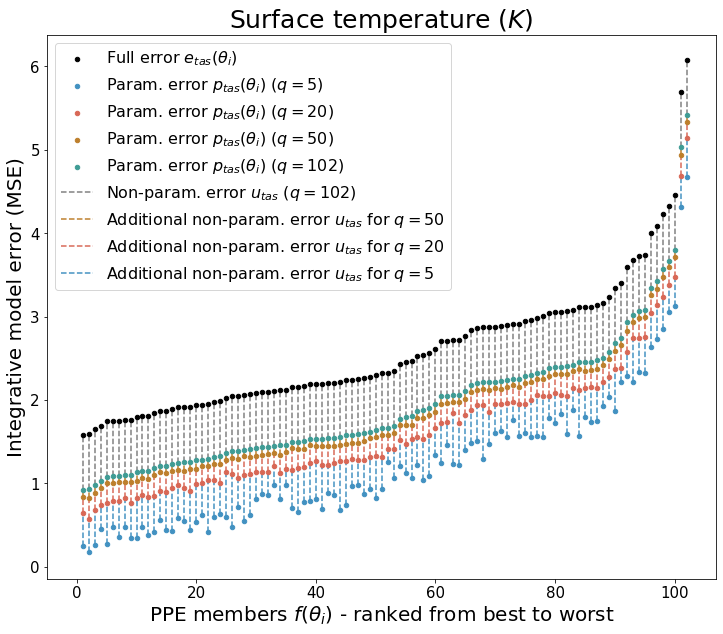

In [99]:
fig, ax = plt.subplots(figsize=(12,10))

df_fig_sort.plot(kind='scatter', x='members', y='ej', 
                           color='black', alpha=1, style='o', zorder=15, ax = ax)


df_fig_sort.plot(kind='scatter', x='members', y='pj 5 modes', 
                           color=rgb_temp[50], 
                 alpha=1, style='o', zorder=15,  ax = ax)  

df_fig_sort.plot(kind='scatter', x='members', y='pj 20 modes', 
                           color=rgb_temp[200], 
                 alpha=1, style='o', zorder=15,  ax = ax) 

df_fig_sort.plot(kind='scatter', x='members', y='pj 50 modes', 
                           color=rgb_prec[50], 
                 alpha=1, style='o', zorder=15,  ax = ax) 

df_fig_sort.plot(kind='scatter', x='members', y='pj 102 modes', 
                           color=rgb_prec[200], 
                 alpha=1, style='o', zorder=15,  ax = ax) 
    
cpt=1
cpt_2 = 0
for i in df_fig_sort['ej'] :
    tmp = df_fig_sort['pj 102 modes'].reset_index().drop('index', axis=1)
    ymin = tmp.iloc[cpt_2]
    plt.vlines(cpt,ymin,ymax = i, 
               colors='grey', linestyles='dashed')
    plt.vlines(200,ymin,ymax = i, 
               colors=rgb_prec[50], linestyles='dashed')
    plt.vlines(200,ymin,ymax = i, 
               colors=rgb_temp[200], linestyles='dashed')
    plt.vlines(200,ymin,ymax = i, 
               colors=rgb_temp[50], linestyles='dashed')
    cpt+=1
    cpt_2+=1
    
cpt=1
cpt_2 = 0
for i in df_fig_sort['pj 102 modes'] :
    tmp = df_fig_sort['pj 50 modes'].reset_index().drop('index', axis=1)
    ymin = tmp.iloc[cpt_2]
    plt.vlines(cpt,ymin,ymax = i, 
               colors=rgb_prec[50], linestyles='dashed')
    cpt+=1
    cpt_2+=1
    
cpt=1
cpt_2 = 0
for i in df_fig_sort['pj 50 modes'] :
    tmp = df_fig_sort['pj 20 modes'].reset_index().drop('index', axis=1)
    ymin = tmp.iloc[cpt_2]
    plt.vlines(cpt,ymin,ymax = i, 
               color=rgb_temp[200], linestyles='dashed')
    cpt+=1
    cpt_2+=1

cpt=1
cpt_2 = 0
for i in df_fig_sort['pj 20 modes'] :
    tmp = df_fig_sort['pj 5 modes'].reset_index().drop('index', axis=1)
    ymin = tmp.iloc[cpt_2]
    plt.vlines(cpt,ymin,ymax = i, 
               color=rgb_temp[50], linestyles='dashed')
    cpt+=1
    cpt_2+=1

legend=['Full error $e_{tas}(\\theta_i)$', 
        'Param. error $p_{tas}(\\theta_i)$ ($q=5$)', 
        'Param. error $p_{tas}(\\theta_i)$ ($q=20$)',
        'Param. error $p_{tas}(\\theta_i)$ ($q=50$)',
        'Param. error $p_{tas}(\\theta_i)$ ($q=102$)',
        'Non-param. error $u_{tas}$ ($q=102$)',
       'Additional non-param. error $u_{tas}$ for $q=50$',
       'Additional non-param. error $u_{tas}$ for $q=20$',
       'Additional non-param. error $u_{tas}$ for $q=5$']

ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, loc='upper left') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Surface temperature ($K$)', fontsize = 25)
plt.xlabel('Models - ranked from best to worst',fontsize=20)
plt.ylabel('Integrative model error (RMSE)', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=16, loc='upper left') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Surface temperature ($K$)', fontsize = 25)
plt.xlabel('PPE members $f(\\theta_i)$ - ranked from best to worst',fontsize=20)
plt.ylabel('Integrative model error (MSE)', fontsize=20)
plt.xlim(-5,107)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/PPE/figures/PPE_ej_decompo_example_"+variable+".png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

# Figure - correlation

In [75]:
def correlation(df_fig, q) :
    res = stats.linregress(df_fig['pj '+str(q)+' modes'], df_fig['ej'])
    x = np.arange(0.2,5.8,0.02)
    line = res.intercept + res.slope*x
    
    r = res.rvalue
    r_round = round(r,3)
    
    return [line, r_round]

In [76]:
corr = {}
## -- 5 modes :
q = 5
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 20 modes :
q = 20
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 50 modes :
q = 50
corr[str(q)+' modes'] = correlation(df_fig, q)

## -- 102 modes :
q = 102
corr[str(q)+' modes'] = correlation(df_fig, q)

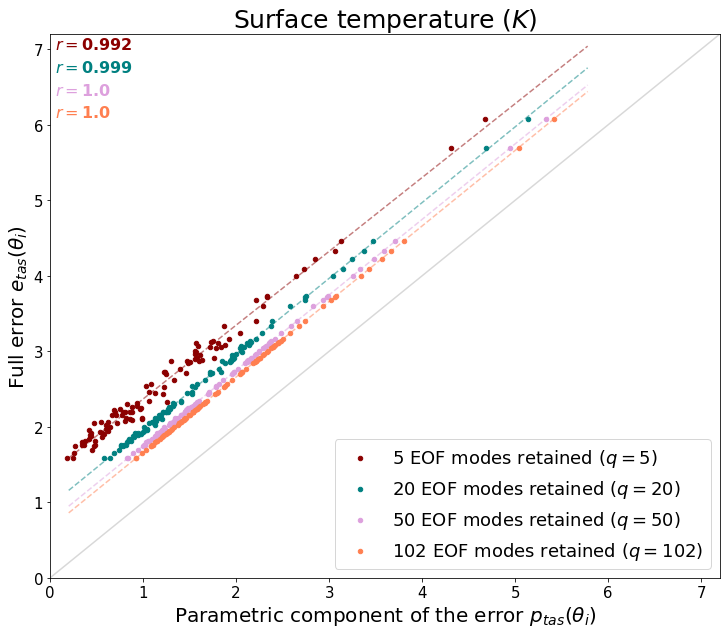

In [77]:
fig, ax = plt.subplots(figsize=(12,10))

## -- Regression line for different q
q=5
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], 
        linestyle='--', alpha=0.5,  color='darkred', 
        label='_nolegend_', zorder =20)
q=20
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], 
        linestyle='--', alpha=0.5,  color='teal', 
        label='_nolegend_', zorder =20)
q=50
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], linestyle='--', alpha=0.5,  
        color='plum', 
        label='_nolegend_', zorder =20)
q=102
ax.plot(np.arange(0.2,5.8,0.02), corr[str(q)+' modes'][0], linestyle='--', alpha=0.5,  
        color='coral', 
        label='_nolegend_', zorder =20)

## -- Scatter plot for different q
q=5
df_fig_sort.plot(kind='scatter', x='pj 5 modes', y='ej', 
                           color='darkred', alpha=1, marker='o', ax = ax, zorder =1)
q=20
df_fig_sort.plot(kind='scatter', x='pj 20 modes', y='ej', 
                           color='teal', alpha=1, marker='o', ax = ax, zorder =1)
q=50
df_fig_sort.plot(kind='scatter', x='pj 50 modes', y='ej', 
                           color='plum', alpha=1, marker='o', ax = ax, zorder =1)
q=102
df_fig_sort.plot(kind='scatter', x='pj 102 modes', y='ej', 
                           color='coral', alpha=1, marker='o', ax = ax, zorder =1)



## -- Regression line for the diagonal (0,0)
ax.plot(np.arange(0.0,10.0,0.02), np.arange(0.0,10.0,0.02), 
        linestyle="-", alpha=0.3,  color='gray', 
        label='_nolegend_')

## -- Legend and settings
legend=['5 EOF modes retained ($q=5$)', 
        '20 EOF modes retained ($q=20$)', 
        '50 EOF modes retained ($q=50$)', 
        '102 EOF modes retained ($q=102$)']
#ax.text(x=1.6, y=0.7, s='Pearson correlation coefficients :', fontsize=16)
ax.text(x=0.05, y=7.0, s='$r = $'+str(corr['5 modes'][1]), fontsize=16, 
        color='darkred', fontweight='bold')
ax.text(x=0.05, y=6.7, s='$r = $'+str(corr['20 modes'][1]), fontsize=16, 
        color='teal', fontweight='bold')
ax.text(x=0.05, y=6.4, s='$r = $'+str(corr['50 modes'][1]), fontsize=16, 
        color='plum', fontweight='bold')
ax.text(x=0.05, y=6.1, s='$r = $'+str(corr['102 modes'][1]), fontsize=16, 
        color='coral', fontweight='bold')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, loc='lower right') #, bbox_to_anchor=(1.5, 1.02))
plt.title('Surface temperature ($K$)', fontsize = 25)
plt.xlabel('Parametric component of the error $p_{tas}(\\theta_i)$',fontsize=20)
plt.ylabel('Full error $e_{tas}(\\theta_i)$',fontsize=20)
plt.ylim(0,7.2)
plt.xlim(0,7.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/Corr_decompo_example_"+variable+".png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()